# 3D Convolutional Neural Network for Tomographic Alignment

## Expanding the Network: ResNet

Since based on previous analysis it is likely that the network was too small to properly identify the features necessary for alignment, the next logical step is to expand the network. Making deeper neural networks usually results in diminishing returns, but residual neural networks have proven to successfully allow for deeper neural networks. Now this model structure will be used in order to find some form of convergence.

In [1]:
# Import essential packages
import os
import math
import numpy as np
import matplotlib.pyplot as plt

# Import tomography and imaging packages
import tomopy
from skimage.transform import rotate, AffineTransform
from skimage import transform as tf

# Import neural net packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.profiler
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torchinfo import summary

In [2]:
# Checking to ensure environment and cuda are correct
print("Working Environment: {}".format(os.environ['CONDA_DEFAULT_ENV']))
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print("Cuda Version: {}".format(torch.version.cuda))
print("Cuda Availability: {}".format(torch.cuda.is_available()))
!pwd

Working Environment: pytorch
Cuda Version: 11.8
Cuda Availability: True
/home/liam/Projects/Tomographic Alignment


In [3]:
# Loading data, 25 entries of 128 resolution shepp3ds
res = 128
entries = 25
data = []

for i in range(entries):
    data.append(np.load('./shepp{}-{}/shepp{}-{}_{}.npy'.format(res, entries, res, entries, i), 
                        allow_pickle = True))
    
data = np.asarray(data) 

In [4]:
# Checking shape of training and testing splits
trainset, testset = np.split(data, [int(entries * 4 / 5)])
print(trainset.shape)
print(testset.shape)

(20, 2)
(5, 2)


In [5]:
# Normalize data
def norm(proj):
    proj = (proj - torch.min(proj)) / (torch.max(proj) - torch.min(proj))
    return proj

# Get inplanes for resnet
def get_inplanes():
    return [64, 128, 256, 512]


# Preset for a 3x3x3 kernel convolution
def conv3x3x3(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=3,
                     stride=stride,
                     padding=1,
                     bias=False)


# Preset for a 1x1x1 kernel convolution
def conv1x1x1(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=1,
                     stride=stride,
                     bias=False)

# Basic block for resnet
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv3x3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3x3(planes, planes)
        self.bn2 = nn.BatchNorm3d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
    
# Bottleneck block for resnet
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv1x1x1(in_planes, planes)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = conv3x3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = conv1x1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm3d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
    

# Resnet structure
class ResNet(nn.Module):

    def __init__(self,
                 block,
                 layers,
                 block_inplanes,
                 n_input_channels=1,
                 conv1_t_size=7,
                 conv1_t_stride=1,
                 no_max_pool=False,
                 shortcut_type='B',
                 widen_factor=1.0,
                 n_classes=360):
        super().__init__()

        block_inplanes = [int(x * widen_factor) for x in block_inplanes]

        self.in_planes = block_inplanes[0]
        self.no_max_pool = no_max_pool

        self.conv1 = nn.Conv3d(n_input_channels,
                               self.in_planes,
                               kernel_size=(conv1_t_size, 7, 7),
                               stride=(conv1_t_stride, 2, 2),
                               padding=(conv1_t_size // 2, 3, 3),
                               bias=False)
        self.bn1 = nn.BatchNorm3d(self.in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, block_inplanes[0], layers[0],
                                       shortcut_type)
        self.layer2 = self._make_layer(block,
                                       block_inplanes[1],
                                       layers[1],
                                       shortcut_type,
                                       stride=2)
        self.layer3 = self._make_layer(block,
                                       block_inplanes[2],
                                       layers[2],
                                       shortcut_type,
                                       stride=2)
        self.layer4 = self._make_layer(block,
                                       block_inplanes[3],
                                       layers[3],
                                       shortcut_type,
                                       stride=2)

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(block_inplanes[3] * block.expansion, n_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _downsample_basic_block(self, x, planes, stride):
        out = F.avg_pool3d(x, kernel_size=1, stride=stride)
        zero_pads = torch.zeros(out.size(0), planes - out.size(1), out.size(2),
                                out.size(3), out.size(4))
        if isinstance(out.data, torch.cuda.FloatTensor):
            zero_pads = zero_pads.cuda()

        out = torch.cat([out.data, zero_pads], dim=1)

        return out

    # make layer helper function
    def _make_layer(self, block, planes, blocks, shortcut_type, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            
                downsample = nn.Sequential(
                    conv1x1x1(self.in_planes, planes * block.expansion, stride),
                    nn.BatchNorm3d(planes * block.expansion))

        layers = []
        layers.append(
            block(in_planes=self.in_planes,
                  planes=planes,
                  stride=stride,
                  downsample=downsample))
        self.in_planes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        if not self.no_max_pool:
            x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


# Generates form of resnet
def generate_model(model_depth, **kwargs):
    assert model_depth in [10, 18, 34, 50, 101, 152, 200]

    if model_depth == 10:
        model = ResNet(BasicBlock, [1, 1, 1, 1], get_inplanes(), **kwargs)
    elif model_depth == 18:
        model = ResNet(BasicBlock, [2, 2, 2, 2], get_inplanes(), **kwargs)
    elif model_depth == 34:
        model = ResNet(BasicBlock, [3, 4, 6, 3], get_inplanes(), **kwargs)
    elif model_depth == 50:
        model = ResNet(Bottleneck, [3, 4, 6, 3], get_inplanes(), **kwargs)
    elif model_depth == 101:
        model = ResNet(Bottleneck, [3, 4, 23, 3], get_inplanes(), **kwargs)
    elif model_depth == 152:
        model = ResNet(Bottleneck, [3, 8, 36, 3], get_inplanes(), **kwargs)
    elif model_depth == 200:
        model = ResNet(Bottleneck, [3, 24, 36, 3], get_inplanes(), **kwargs)

    return model

In [6]:
model = generate_model(50)
summary(model, (1, 1, 180, 128, 184))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 360]                  --
├─Conv3d: 1-1                            [1, 64, 180, 64, 92]      21,952
├─BatchNorm3d: 1-2                       [1, 64, 180, 64, 92]      128
├─ReLU: 1-3                              [1, 64, 180, 64, 92]      --
├─MaxPool3d: 1-4                         [1, 64, 90, 32, 46]       --
├─Sequential: 1-5                        [1, 256, 90, 32, 46]      --
│    └─Bottleneck: 2-1                   [1, 256, 90, 32, 46]      --
│    │    └─Conv3d: 3-1                  [1, 64, 90, 32, 46]       4,096
│    │    └─BatchNorm3d: 3-2             [1, 64, 90, 32, 46]       128
│    │    └─ReLU: 3-3                    [1, 64, 90, 32, 46]       --
│    │    └─Conv3d: 3-4                  [1, 64, 90, 32, 46]       110,592
│    │    └─BatchNorm3d: 3-5             [1, 64, 90, 32, 46]       128
│    │    └─ReLU: 3-6                    [1, 64, 90, 32, 46]       --


In [7]:
# Train the model

# Create writer and profiler to analyze loss over each epoch
writer = SummaryWriter()

# Set device to CUDA if available, initialize model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device: {}'.format(device))
net = generate_model(50)
net.to(device)

# Set up optimizer and loss function, set number of epochs
optimizer = optim.SGD(net.parameters(), lr = 5e-2, momentum=0.9, weight_decay = 0)
criterion = nn.MSELoss(reduction = 'mean')
criterion.to(device)
num_epochs = 500

# Iniitializing variables to show statistics
iteration = 0
test_iteration = 0
loss_list = []
test_loss_list = []
epoch_loss_averages = []
test_epoch_loss_averages = []

# Iterates over dataset multiple times
for epoch in range(num_epochs):
    
    epoch_loss = 0
    test_epoch_loss = 0
    
    for i, data in enumerate(trainset, 0):
        
        inputs, truths = norm(torch.from_numpy(data[0]).to(device)), torch.from_numpy(data[1]).to(device).float()
        optimizer.zero_grad()

        outputs = net(inputs).to(device)
        loss = criterion(outputs, truths)
        writer.add_scalar("Loss / Train", loss, epoch) # adds training loss scalar
        loss_list.append(loss.cpu().detach().numpy())
        epoch_loss += loss.cpu().detach().numpy()
        loss.backward()
        optimizer.step()

        iteration += 1
        if iteration % trainset.shape[0] == 0:
            epoch_loss_averages.append(epoch_loss / trainset.shape[0])
            print('Epoch: {}   Training Loss: {} '.format(epoch, epoch_loss / trainset.shape[0]))
            
    for i, test_data in enumerate(testset, 0):
        
        inputs, truths = norm(torch.from_numpy(test_data[0]).to(device)), torch.from_numpy(test_data[1]).to(device).float()
        outputs = net(inputs).to(device)
        test_loss = criterion(outputs, truths)
        
        writer.add_scalar("Loss / Test", test_loss, epoch) # adds testing loss scalar
        test_loss_list.append(test_loss.cpu().detach().numpy())
        test_epoch_loss += test_loss.cpu().detach().numpy()
        
        test_iteration +=1
        if test_iteration % testset.shape[0] == 0:
            test_epoch_loss_averages.append(test_epoch_loss / testset.shape[0])
            print('Epoch: {}   Validation Loss: {} '.format(epoch, test_epoch_loss / testset.shape[0]))
            
writer.flush()
writer.close()

Device: cuda:0
Epoch: 0   Training Loss: 12.31634168624878 
Epoch: 0   Validation Loss: 8.745484352111816 
Epoch: 1   Training Loss: 8.704384207725525 
Epoch: 1   Validation Loss: 8.571128845214844 
Epoch: 2   Training Loss: 8.476190543174743 
Epoch: 2   Validation Loss: 8.159250450134277 
Epoch: 3   Training Loss: 8.363746762275696 
Epoch: 3   Validation Loss: 8.180633449554444 
Epoch: 4   Training Loss: 8.314012169837952 
Epoch: 4   Validation Loss: 8.201206684112549 
Epoch: 5   Training Loss: 8.305513143539429 
Epoch: 5   Validation Loss: 8.211517238616944 
Epoch: 6   Training Loss: 8.300348281860352 
Epoch: 6   Validation Loss: 8.215264797210693 
Epoch: 7   Training Loss: 8.295539402961731 
Epoch: 7   Validation Loss: 8.218183994293213 
Epoch: 8   Training Loss: 8.291425275802613 
Epoch: 8   Validation Loss: 8.22093505859375 
Epoch: 9   Training Loss: 8.288200640678406 
Epoch: 9   Validation Loss: 8.222156715393066 
Epoch: 10   Training Loss: 8.284827375411988 
Epoch: 10   Validati

Epoch: 88   Training Loss: 7.945837354660034 
Epoch: 88   Validation Loss: 8.493920993804931 
Epoch: 89   Training Loss: 8.114667558670044 
Epoch: 89   Validation Loss: 8.464743041992188 
Epoch: 90   Training Loss: 8.245215773582458 
Epoch: 90   Validation Loss: 8.316209316253662 
Epoch: 91   Training Loss: 8.320222330093383 
Epoch: 91   Validation Loss: 8.314917469024659 
Epoch: 92   Training Loss: 8.237339425086976 
Epoch: 92   Validation Loss: 8.273200702667236 
Epoch: 93   Training Loss: 8.19527096748352 
Epoch: 93   Validation Loss: 8.267593002319336 
Epoch: 94   Training Loss: 8.157834529876709 
Epoch: 94   Validation Loss: 8.263912677764893 
Epoch: 95   Training Loss: 8.115793561935424 
Epoch: 95   Validation Loss: 8.263623142242432 
Epoch: 96   Training Loss: 8.110970711708068 
Epoch: 96   Validation Loss: 8.266850852966309 
Epoch: 97   Training Loss: 8.092350459098816 
Epoch: 97   Validation Loss: 8.236651992797851 
Epoch: 98   Training Loss: 8.108911037445068 
Epoch: 98   Val

Epoch: 174   Training Loss: 5.363795429468155 
Epoch: 174   Validation Loss: 9.72459897994995 
Epoch: 175   Training Loss: 5.468208503723145 
Epoch: 175   Validation Loss: 9.668217658996582 
Epoch: 176   Training Loss: 4.911032006144524 
Epoch: 176   Validation Loss: 9.484431076049805 
Epoch: 177   Training Loss: 4.773486861586571 
Epoch: 177   Validation Loss: 9.283726978302003 
Epoch: 178   Training Loss: 4.794860523939133 
Epoch: 178   Validation Loss: 10.175553226470948 
Epoch: 179   Training Loss: 4.997452431917191 
Epoch: 179   Validation Loss: 9.749754047393798 
Epoch: 180   Training Loss: 4.827223712205887 
Epoch: 180   Validation Loss: 9.491836738586425 
Epoch: 181   Training Loss: 4.63899425715208 
Epoch: 181   Validation Loss: 9.369819641113281 
Epoch: 182   Training Loss: 4.402202634513378 
Epoch: 182   Validation Loss: 9.93648853302002 
Epoch: 183   Training Loss: 4.720025031268596 
Epoch: 183   Validation Loss: 9.741913318634033 
Epoch: 184   Training Loss: 6.617167812585

Epoch: 259   Training Loss: 0.06609459053725004 
Epoch: 259   Validation Loss: 11.345127296447753 
Epoch: 260   Training Loss: 0.03391454860102385 
Epoch: 260   Validation Loss: 11.357624053955078 
Epoch: 261   Training Loss: 0.02857220491860062 
Epoch: 261   Validation Loss: 11.469128608703613 
Epoch: 262   Training Loss: 0.013360103452578187 
Epoch: 262   Validation Loss: 11.414515495300293 
Epoch: 263   Training Loss: 0.010657266085036098 
Epoch: 263   Validation Loss: 11.35171127319336 
Epoch: 264   Training Loss: 0.006780894479015842 
Epoch: 264   Validation Loss: 11.398759460449218 
Epoch: 265   Training Loss: 0.004074943903833628 
Epoch: 265   Validation Loss: 11.437602233886718 
Epoch: 266   Training Loss: 0.003649523033527657 
Epoch: 266   Validation Loss: 11.37564582824707 
Epoch: 267   Training Loss: 0.0019350051326910034 
Epoch: 267   Validation Loss: 11.365783882141113 
Epoch: 268   Training Loss: 0.0020941787632182242 
Epoch: 268   Validation Loss: 11.422950172424317 
Epo

Epoch: 341   Training Loss: 8.404348662338635e-07 
Epoch: 341   Validation Loss: 11.39468994140625 
Epoch: 342   Training Loss: 5.738785453957007e-07 
Epoch: 342   Validation Loss: 11.39342212677002 
Epoch: 343   Training Loss: 7.505498182069914e-07 
Epoch: 343   Validation Loss: 11.39500617980957 
Epoch: 344   Training Loss: 5.700447843537404e-07 
Epoch: 344   Validation Loss: 11.395443153381347 
Epoch: 345   Training Loss: 5.556342649981616e-07 
Epoch: 345   Validation Loss: 11.393869400024414 
Epoch: 346   Training Loss: 5.801042817665802e-07 
Epoch: 346   Validation Loss: 11.394408226013184 
Epoch: 347   Training Loss: 3.949354528742788e-07 
Epoch: 347   Validation Loss: 11.395348930358887 
Epoch: 348   Training Loss: 5.485640699021133e-07 
Epoch: 348   Validation Loss: 11.394435501098632 
Epoch: 349   Training Loss: 3.7196941526929095e-07 
Epoch: 349   Validation Loss: 11.39364242553711 
Epoch: 350   Training Loss: 4.4021559304496803e-07 
Epoch: 350   Validation Loss: 11.395123672

Epoch: 423   Training Loss: 1.8970553417041457e-08 
Epoch: 423   Validation Loss: 11.394395637512208 
Epoch: 424   Training Loss: 2.433498764720099e-08 
Epoch: 424   Validation Loss: 11.394439888000488 
Epoch: 425   Training Loss: 1.702393253033563e-08 
Epoch: 425   Validation Loss: 11.394534492492676 
Epoch: 426   Training Loss: 2.522183135678091e-08 
Epoch: 426   Validation Loss: 11.394308280944824 
Epoch: 427   Training Loss: 2.7255794754488248e-08 
Epoch: 427   Validation Loss: 11.394481468200684 
Epoch: 428   Training Loss: 2.3933916060148164e-08 
Epoch: 428   Validation Loss: 11.394665908813476 
Epoch: 429   Training Loss: 3.1619259299731085e-08 
Epoch: 429   Validation Loss: 11.394514846801759 
Epoch: 430   Training Loss: 2.444952045266291e-08 
Epoch: 430   Validation Loss: 11.39447078704834 
Epoch: 431   Training Loss: 2.5930510383354034e-08 
Epoch: 431   Validation Loss: 11.394655227661133 
Epoch: 432   Training Loss: 3.0010488494269796e-08 
Epoch: 432   Validation Loss: 11.39

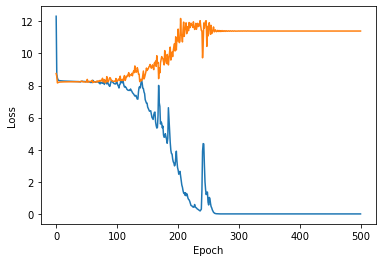

In [8]:
# Plot epoch loss to test for convergence
plt.plot(epoch_loss_averages)
plt.plot(test_epoch_loss_averages)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

As we can see, a small dataset shows convergence which means this network MAY be able to be a solution. The next step is to test on a significantly larger dataset to see if this can deal with the overfitting problem. If the large set has convergence in the training data with a larger set then the overfitting must be dealt with in another way